# Station S3 analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers
import seaborn as sns

%matplotlib inline

### To recreate this notebook at a different location, follow these instructions: 

In [4]:
# The path to the directory where the pickle files are stored:
savedir='/ocean/aisabell/MEOPAR/extracted_files'
# Change 'S3' to the location of interest
loc='S3'
# What is the start year and end year+1 of the time range of interest?
startyear=2007
endyear=2021 # does NOT include this value
# Note: What is the model run?

# Note: non-location specific variables only need to be done for each year, not for each location
# Note: xticks in the plots will need to be changed
# Note: 201812 bloom timing variable load and plotting will also need to be removed

1.1363636363636362

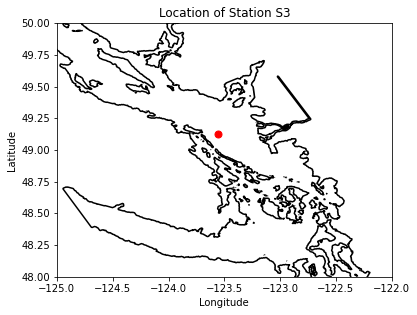

In [5]:
modver='201905'
# lat and lon information for place:
lon,lat=places.PLACES[loc]['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES[loc]['NEMO grid ji']
jw,iw=places.PLACES[loc]['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station %s'%loc)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

### Strait of Georgia Region:

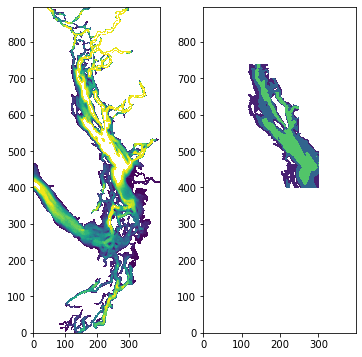

In [6]:
# define sog region:
fig, ax = plt.subplots(1,2,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bath=np.array(bathy.Bathymetry)
ax[0].contourf(bath,np.arange(0,250,10))
viz_tools.set_aspect(ax[0],coords='grid')
sogmask=np.copy(tmask[:,:,:,:])
sogmask[:,:,740:,:]=0
sogmask[:,:,700:,170:]=0
sogmask[:,:,550:,250:]=0
sogmask[:,:,:,302:]=0
sogmask[:,:,:400,:]=0
sogmask[:,:,:,:100]=0
#sogmask250[bath<250]=0
ax[1].contourf(np.ma.masked_where(sogmask[0,0,:,:]==0,bathy.Bathymetry),[0,100,250,550])

###  *** Stop and check, have you made pickle files for all the years? ***

In [7]:
# loop through years of spring time series (mid feb-june) for bloom timing for 201905 run
years=list()
bloomtime1=list()
bloomtime2=list()
bloomtime3=list()
for year in range(startyear,endyear):
    fname3=f'springBloomTime_{str(year)}_{loc}_{modver}.pkl'
    savepath3=os.path.join(savedir,fname3)
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))
    # put code that calculates bloom timing here
    bt1=bloomdrivers.metric1_bloomtime(phyto_alld0,no3_alld0,bio_time0)
    bt2=bloomdrivers.metric2_bloomtime(sphyto0,sno30,bio_time0)
    bt3=bloomdrivers.metric3_bloomtime(sphyto0,sno30,bio_time0)
    years.append(year)
    bloomtime1.append(bt1)
    bloomtime2.append(bt2)
    bloomtime3.append(bt3)   
years=np.array(years)
bloomtime1=np.array(bloomtime1)
bloomtime2=np.array(bloomtime2)
bloomtime3=np.array(bloomtime3)

# get year day
yearday1=et.datetimeToYD(bloomtime1)  # convert to year day tool
yearday2=et.datetimeToYD(bloomtime2)
yearday3=et.datetimeToYD(bloomtime3)

### Combine separate year files into arrays:

In [8]:
# loop through years (for location specific drivers)

years=list()
windjan=list()
windfeb=list()
windmar=list()
solarjan=list()
solarfeb=list()
solarmar=list()
parjan=list()
parfeb=list()
parmar=list()
tempjan=list()
tempfeb=list()
tempmar=list()
saljan=list()
salfeb=list()
salmar=list()
zoojan=list()
zoofeb=list()
zoomar=list()
mesozoojan=list()
mesozoofeb=list()
mesozoomar=list()
microzoojan=list()
microzoofeb=list()
microzoomar=list()
intzoojan=list()
intzoofeb=list()
intzoomar=list()
intmesozoojan=list()
intmesozoofeb=list()
intmesozoomar=list()
intmicrozoojan=list()
intmicrozoofeb=list()
intmicrozoomar=list()
midno3jan=list()
midno3feb=list()
midno3mar=list()

for year in range(startyear,endyear):
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    wind=bloomdrivers.janfebmar_wspeed3(twind,wspeed)
    solar=bloomdrivers.janfebmar_irradiance(twind,solar)
    par=bloomdrivers.janfebmar_spar(bio_time,spar)
    temp=bloomdrivers.janfebmar_temp(grid_time,temp)
    sal=bloomdrivers.janfebmar_temp(grid_time,salinity)
    zoo=bloomdrivers.janfebmar_zooplankton(bio_time,zoop_alld)
    mesozoo=bloomdrivers.janfebmar_mesozooplankton(bio_time,mesozoo_alld)
    microzoo=bloomdrivers.janfebmar_microzooplankton(bio_time,microzoo_alld)
    intzoo=bloomdrivers.janfebmar_depth_intzoop(bio_time,intzoop)
    intmesozoo=bloomdrivers.janfebmar_depth_intmesozoop(bio_time,intmesoz)
    intmicrozoo=bloomdrivers.janfebmar_depth_intmicrozoop(bio_time,intmicroz)
    midno3=bloomdrivers.janfebmar_mid_depth_no3(bio_time,no3_30to90m)
    
    years.append(year)
    windjan.append(wind[0])
    windfeb.append(wind[1])
    windmar.append(wind[2])   
    solarjan.append(solar[0])
    solarfeb.append(solar[1])
    solarmar.append(solar[2])
    parjan.append(par[0])
    parfeb.append(par[1])
    parmar.append(par[2])
    tempjan.append(temp[0])
    tempfeb.append(temp[1])
    tempmar.append(temp[2])
    saljan.append(sal[0])
    salfeb.append(sal[1])
    salmar.append(sal[2])
    zoojan.append(zoo[0])
    zoofeb.append(zoo[1])
    zoomar.append(zoo[2])
    mesozoojan.append(mesozoo[0])
    mesozoofeb.append(mesozoo[1])
    mesozoomar.append(mesozoo[2])
    microzoojan.append(microzoo[0])
    microzoofeb.append(microzoo[1])
    microzoomar.append(microzoo[2])
    intzoojan.append(intzoo[0])
    intzoofeb.append(intzoo[1])
    intzoomar.append(intzoo[2])
    intmesozoojan.append(intmesozoo[0])
    intmesozoofeb.append(intmesozoo[1])
    intmesozoomar.append(intmesozoo[2])
    intmicrozoojan.append(intmicrozoo[0])
    intmicrozoofeb.append(intmicrozoo[1])
    intmicrozoomar.append(intmicrozoo[2])
    midno3jan.append(midno3[0])
    midno3feb.append(midno3[1])
    midno3mar.append(midno3[2])

years=np.array(years)
windjan=np.array(windjan)
windfeb=np.array(windfeb)
windmar=np.array(windmar)
solarjan=np.array(solarjan)
solarfeb=np.array(solarfeb)
solarmar=np.array(solarmar)
parjan=np.array(parjan)
parfeb=np.array(parfeb)
parmar=np.array(parmar)
tempjan=np.array(tempjan)
tempfeb=np.array(tempfeb)
tempmar=np.array(tempmar)
saljan=np.array(saljan)
salfeb=np.array(salfeb)
salmar=np.array(salmar)
zoojan=np.array(zoojan)
zoofeb=np.array(zoofeb)
zoomar=np.array(zoomar)
mesozoojan=np.array(mesozoojan)
mesozoofeb=np.array(mesozoofeb)
mesozoomar=np.array(mesozoomar)
microzoojan=np.array(microzoojan)
microzoofeb=np.array(microzoofeb)
microzoomar=np.array(microzoomar)
intzoojan=np.array(intzoojan)
intzoofeb=np.array(intzoofeb)
intzoomar=np.array(intzoomar)
intmesozoojan=np.array(intmesozoojan)
intmesozoofeb=np.array(intmesozoofeb)
intmesozoomar=np.array(intmesozoomar)
intmicrozoojan=np.array(intmicrozoojan)
intmicrozoofeb=np.array(intmicrozoofeb)
intmicrozoomar=np.array(intmicrozoomar)
midno3jan=np.array(midno3jan)
midno3feb=np.array(midno3feb)
midno3mar=np.array(midno3mar)

In [9]:
# loop through years (for non-location specific drivers)
fraserjan=list()
fraserfeb=list()
frasermar=list()
deepno3jan=list()
deepno3feb=list()
deepno3mar=list()

for year in range(startyear,endyear):
    fname2=f'JanToMarch_TimeSeries_{year}_{modver}.pkl'
    savepath2=os.path.join(savedir,fname2)
    no3_past250m,riv_time,rivFlow=pickle.load(open(savepath2,'rb'))
    # Code that calculates drivers here
    fraser=bloomdrivers.janfebmar_fraserflow(riv_time,rivFlow)
    fraserjan.append(fraser[0])
    fraserfeb.append(fraser[1])
    frasermar.append(fraser[2])

    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    deepno3=bloomdrivers.janfebmar_deepno3(bio_time,no3_past250m)
 
    deepno3jan.append(deepno3[0])
    deepno3feb.append(deepno3[1])
    deepno3mar.append(deepno3[2])

fraserjan=np.array(fraserjan)
fraserfeb=np.array(fraserfeb)
frasermar=np.array(frasermar)
deepno3jan=np.array(deepno3jan)
deepno3feb=np.array(deepno3feb)
deepno3mar=np.array(deepno3mar)

In [10]:
# loop through years (for mixing drivers)

halojan=list()
halofeb=list()
halomar=list()

for year in range(startyear,endyear):
    fname4=f'JanToMarch_Mixing_{year}_{loc}_{modver}.pkl'
    savepath4=os.path.join(savedir,fname4)
    halocline,eddy,diss,depth=pickle.load(open(savepath4,'rb'))
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    halo=bloomdrivers.janfebmar_halocline(bio_time,halocline)
    halojan.append(halo[0])
    halofeb.append(halo[1])
    halomar.append(halo[2])

halojan=np.array(halojan)
halofeb=np.array(halofeb)
halomar=np.array(halomar)

In [11]:
# January dataframe
dfjan=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windjan,'solar':solarjan,
                  'temp':tempjan,'sal':saljan,'zoo':zoojan,'mesozoo':mesozoojan,'microzo':microzoojan,'intzoo':intzoojan,
                  'intmesozoo':intmesozoojan,'intmicrozoo':intmicrozoojan,'midno3':midno3jan,'fraser':fraserjan,'deepno3':deepno3jan})
# February dataframe
dffeb=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windfeb,'solar':solarfeb,
                  'temp':tempfeb,'sal':salfeb,'zoo':zoofeb,'mesozoo':mesozoofeb,'microzo':microzoofeb,'intzoo':intzoofeb,
                  'intmesozoo':intmesozoofeb,'intmicrozoo':intmicrozoofeb,'midno3':midno3feb,'fraser':fraserfeb,'deepno3':deepno3feb})
# March dataframe
dfmar=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windmar,'solar':solarmar,
                  'temp':tempmar,'sal':salmar,'zoo':zoomar,'mesozoo':mesozoomar,'microzo':microzoomar,'intzoo':intzoomar,
                  'intmesozoo':intmesozoomar,'intmicrozoo':intmicrozoomar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar})

In [12]:
dfjan.cov()

,metric1,metric2,metric3,wind,solar,temp,sal,zoo,mesozoo,microzo,intzoo,intmesozoo,intmicrozoo,midno3,fraser,deepno3
metric1,167.192308,137.846154,128.192308,23.129078,-12.446660,-3.737684,-2.507605,0.032764,0.071477,-0.038714,-1.880364,-1.567099,-0.313262,4.392353,-600.550070,6.741225
metric2,137.846154,179.494505,145.901099,281.294891,-4.938732,-4.977896,-0.353398,-0.201628,-0.048164,-0.153464,1.303911,3.325698,-2.021787,5.227610,-778.202736,7.644347
metric3,128.192308,145.901099,132.335165,166.893530,-8.356181,-4.223339,-1.419171,-0.145257,-0.032298,-0.112959,0.423175,1.852830,-1.429654,4.309779,-801.435591,7.227635
wind,23.129078,281.294891,166.893530,8094.426045,-458.025790,13.867379,40.699889,-4.261744,-2.636023,-1.625720,-14.927398,18.410700,-33.338041,23.576396,-936.027025,14.378985
solar,-12.446660,-4.938732,-8.356181,-458.025790,67.435320,-3.160387,-2.825547,0.362643,0.249446,0.113197,9.920908,6.848084,3.072818,-1.706040,-23.614641,-1.121300
temp,-3.737684,-4.977896,-4.223339,13.867379,-3.160387,0.487680,0.404520,-0.014878,-0.014082,-0.000796,-0.512877,-0.423452,-0.089425,-0.077289,44.577452,-0.310055
sal,-2.507605,-0.353398,-1.419171,40.699889,-2.825547,0.404520,0.863035,-0.034085,-0.025455,-0.008629,-0.029315,0.145581,-0.174896,0.104467,-18.401152,-0.248327
zoo,0.032764,-0.201628,-0.145257,-4.261744,0.362643,-0.014878,-0.034085,0.003774,0.002344,0.001430,0.065536,0.033355,0.032181,-0.011621,1.421366,-0.010426
mesozoo,0.071477,-0.048164,-0.032298,-2.636023,0.249446,-0.014082,-0.025455,0.002344,0.001638,0.000706,0.034419,0.018400,0.016019,-0.003248,0.094746,-0.000974
microzo,-0.038714,-0.153464,-0.112959,-1.625720,0.113197,-0.000796,-0.008629,0.001430,0.000706,0.000724,0.031117,0.014954,0.016162,-0.008373,1.326619,-0.009452


In [13]:
dffeb.cov()

,metric1,metric2,metric3,wind,solar,temp,sal,zoo,mesozoo,microzo,intzoo,intmesozoo,intmicrozoo,midno3,fraser,deepno3
metric1,167.192308,137.846154,128.192308,274.279459,-53.858452,-0.713898,-4.898713,-0.001092,0.022176,-0.023268,1.623116,2.423631,-0.800515,3.904678,-939.299268,6.694636
metric2,137.846154,179.494505,145.901099,360.325660,-28.377121,-6.032933,-5.024165,0.034262,0.121864,-0.087603,8.283282,10.722873,-2.439585,4.232697,-2148.530053,7.522579
metric3,128.192308,145.901099,132.335165,291.662420,-37.739568,-4.270886,-5.689764,0.117363,0.137406,-0.020043,9.183340,9.975303,-0.791959,3.862083,-1862.155986,7.144473
wind,274.279459,360.325660,291.662420,2108.504590,-133.188560,-10.889928,15.694070,-0.880833,-0.464368,-0.416465,6.326425,15.158604,-8.832167,9.299857,-5281.416721,15.042285
solar,-53.858452,-28.377121,-37.739568,-133.188560,58.542495,-0.877576,2.507346,-0.090112,-0.074038,-0.016073,-3.656525,-3.459894,-0.196629,-1.635060,240.859673,-3.642172
temp,-0.713898,-6.032933,-4.270886,-10.889928,-0.877576,0.714746,0.317722,-0.023041,-0.021939,-0.001103,-0.885303,-0.978258,0.092954,-0.152104,183.593070,-0.308140
sal,-4.898713,-5.024165,-5.689764,15.694070,2.507346,0.317722,1.535570,-0.049546,-0.041100,-0.008446,-0.861949,-0.867015,0.005066,0.018919,-60.189150,-0.645027
zoo,-0.001092,0.034262,0.117363,-0.880833,-0.090112,-0.023041,-0.049546,0.003273,0.002075,0.001198,0.052124,0.034909,0.017215,-0.000179,-4.309823,0.016587
mesozoo,0.022176,0.121864,0.137406,-0.464368,-0.074038,-0.021939,-0.041100,0.002075,0.001780,0.000295,0.048484,0.050430,-0.001946,0.003440,-4.112235,0.018417
microzo,-0.023268,-0.087603,-0.020043,-0.416465,-0.016073,-0.001103,-0.008446,0.001198,0.000295,0.000904,0.003639,-0.015522,0.019161,-0.003619,-0.197588,-0.001830


In [14]:
dfmar.cov()

,metric1,metric2,metric3,wind,solar,temp,sal,zoo,mesozoo,microzo,intzoo,intmesozoo,intmicrozoo,midno3,fraser,deepno3
metric1,167.192308,137.846154,128.192308,683.907352,-182.929908,-2.243489,4.867424,-4.709155,-2.555837,-2.153319,-27.604591,0.764202,-28.368785,5.951665,-850.715675,6.772832
metric2,137.846154,179.494505,145.901099,754.719649,-181.010106,-6.634223,5.431145,-5.283798,-2.862842,-2.420956,-15.977233,13.208109,-29.185338,7.012743,-3185.425422,7.515965
metric3,128.192308,145.901099,132.335165,648.325174,-163.303261,-4.494384,4.504952,-4.476218,-2.505167,-1.971051,-22.973640,3.707066,-26.680701,6.459397,-2129.210389,7.127748
wind,683.907352,754.719649,648.325174,5149.923947,-1106.450749,-20.041112,33.947953,-28.015315,-16.139144,-11.876172,-75.728270,58.703642,-134.431857,35.910364,-2988.681860,42.878490
solar,-182.929908,-181.010106,-163.303261,-1106.450749,401.115077,2.802207,-6.910096,6.335157,3.861093,2.474064,40.938807,4.977621,35.961176,-5.339316,-1722.072976,-8.563671
temp,-2.243489,-6.634223,-4.494384,-20.041112,2.802207,0.460763,-0.076910,0.148834,0.076014,0.072820,-0.559974,-1.228624,0.668650,-0.322029,238.741716,-0.324212
sal,4.867424,5.431145,4.504952,33.947953,-6.910096,-0.076910,0.896922,-0.265274,-0.141146,-0.124128,-1.288013,-0.154721,-1.133292,0.248659,-169.872150,-0.129176
zoo,-4.709155,-5.283798,-4.476218,-28.015315,6.335157,0.148834,-0.265274,0.205588,0.110008,0.095580,0.739478,-0.318490,1.057968,-0.243318,76.337408,-0.201007
mesozoo,-2.555837,-2.862842,-2.505167,-16.139144,3.861093,0.076014,-0.141146,0.110008,0.061006,0.049002,0.475958,-0.098954,0.574912,-0.130778,31.005613,-0.122186
microzo,-2.153319,-2.420956,-1.971051,-11.876172,2.474064,0.072820,-0.124128,0.095580,0.049002,0.046578,0.263520,-0.219536,0.483056,-0.112540,45.331797,-0.078821


<AxesSubplot:>

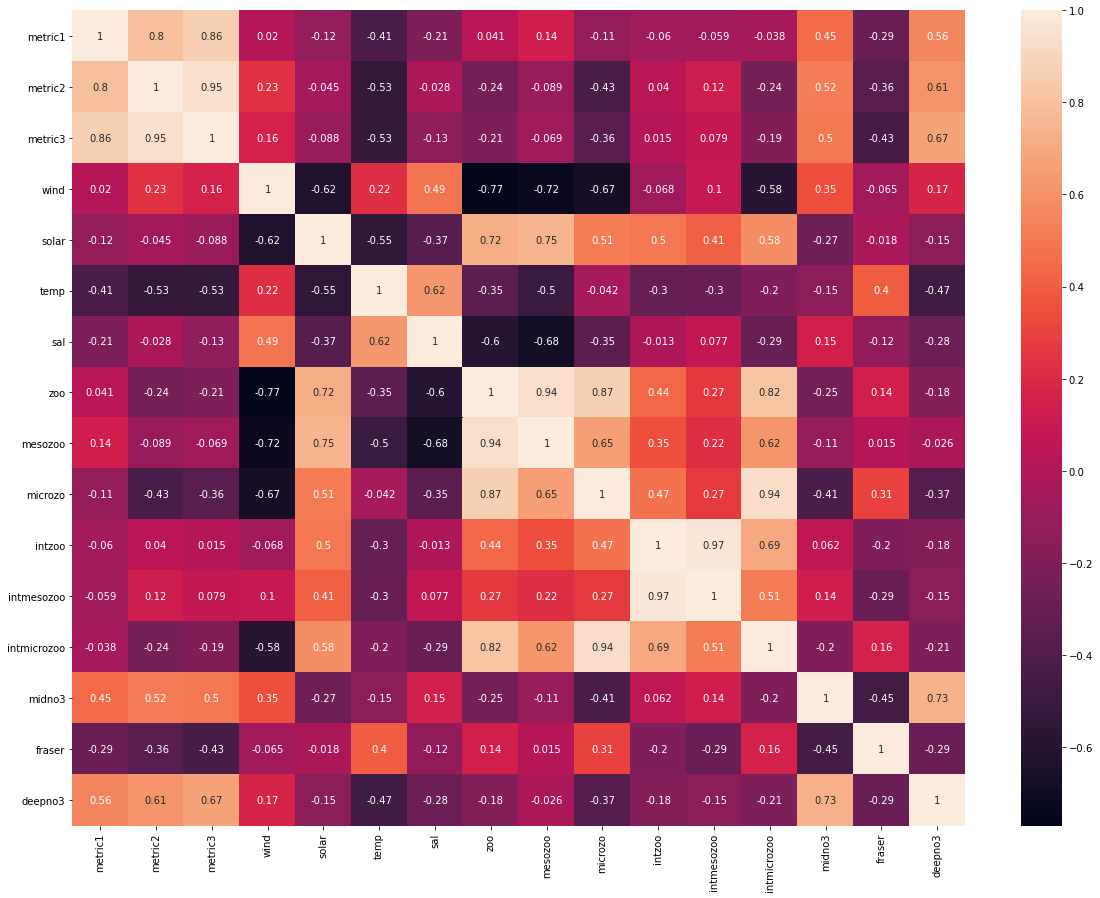

In [16]:
plt.subplots(figsize=(20,15))
sns.heatmap(dfjan.corr(), annot = True)

<AxesSubplot:>

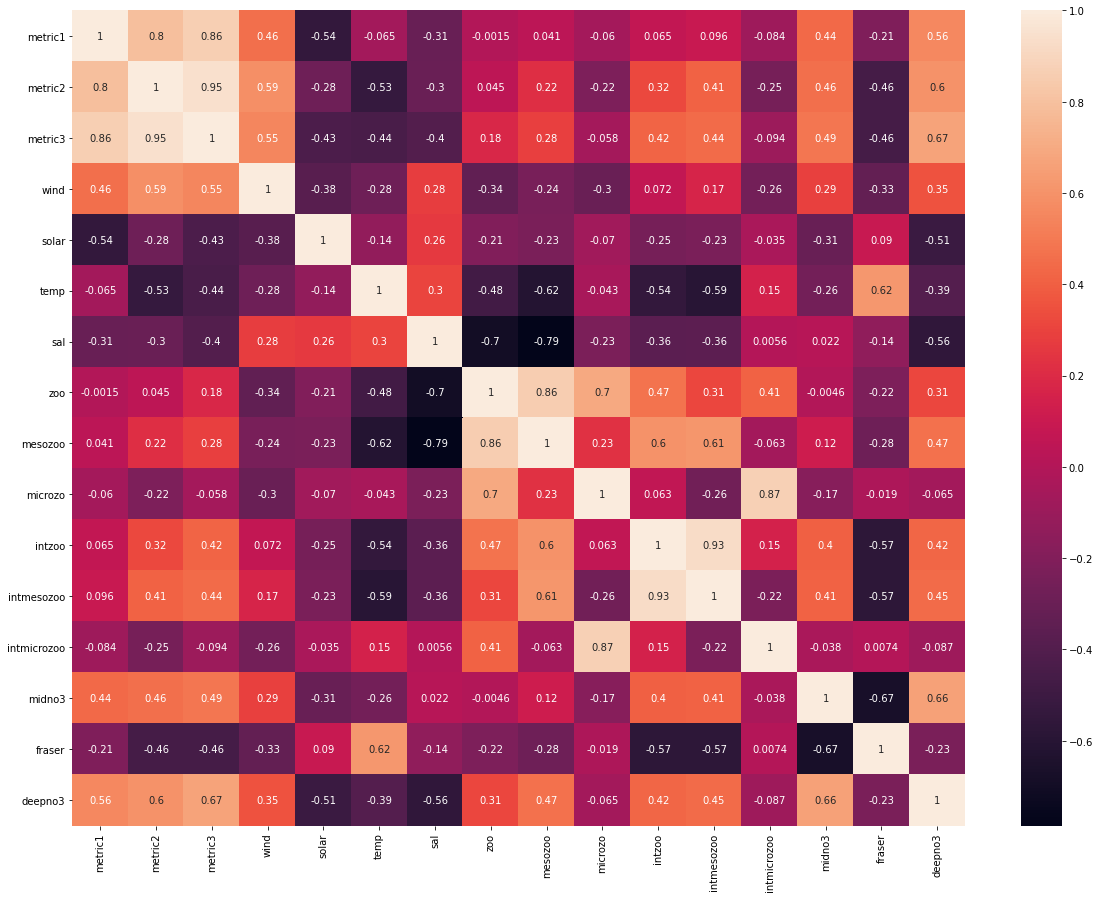

In [17]:
plt.subplots(figsize=(20,15))
sns.heatmap(dffeb.corr(), annot = True)

<AxesSubplot:>

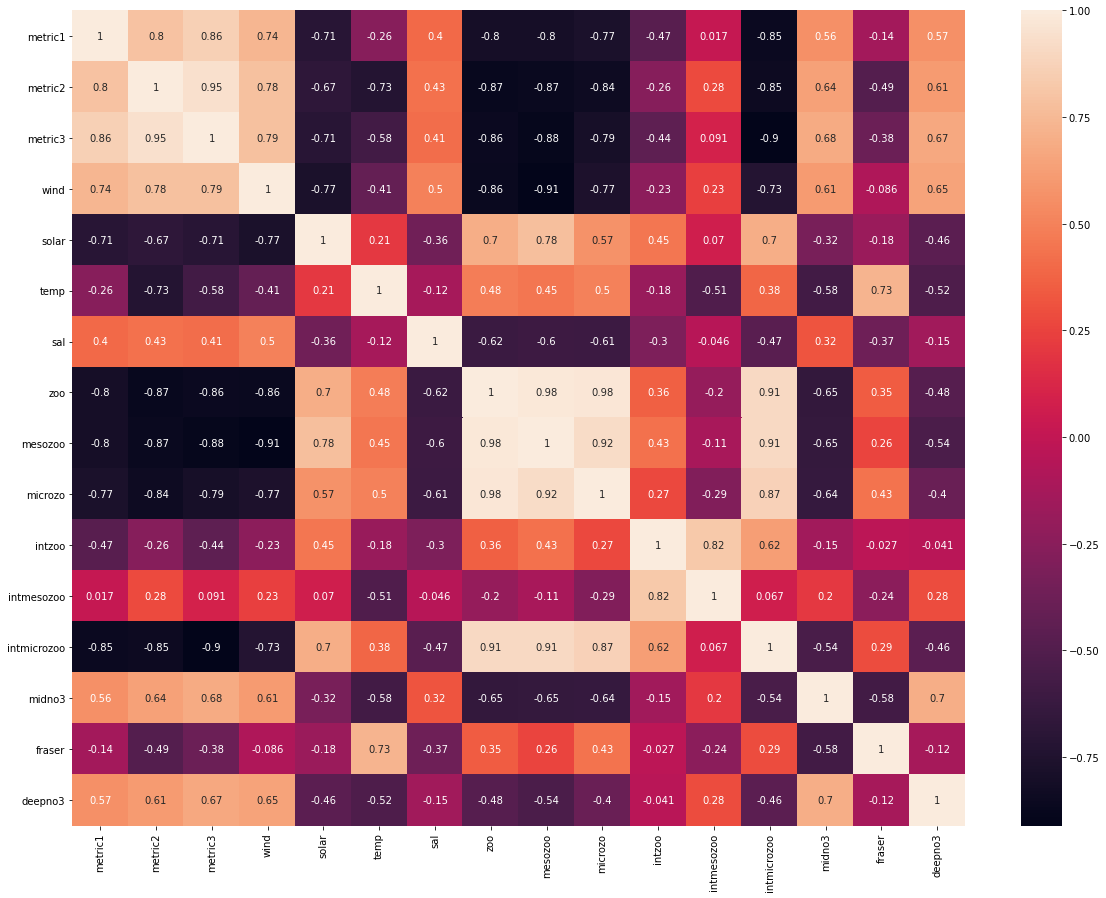

In [19]:
plt.subplots(figsize=(20,15))
sns.heatmap(dfmar.corr(), annot = True)